In [1]:
import pandas as pd
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

# Identify which ICD codes pertain to Diabetes, type1 type2

In [2]:
ICD10 = pd.read_csv('ICD_lut.csv')
pattern1 = 'type 1 diabetes'
pattern2 = 'type 2 diabetes'
ICD_diabetes_1 = set()
ICD_diabetes_2 = set()
for eek in range(0,ICD10.shape[0]):
    #pull line items
    line = ICD10.iloc[eek,:]
    code = line[0]
    descr = str.lower(line[1])
    if pattern1 in descr:
        #add code to set
        ICD_diabetes_1.add(code)
    if pattern2 in descr:
        ICD_diabetes_2.add(code)
    else:
        pass

In [3]:
print(len(ICD_diabetes_1))
print(len(ICD_diabetes_2))

98
104


# Part 1

I have pulled codes for type 1 and type 2, i will compare type 1, type 2, and non:

Methodology:
* chunk through all claims, maybt 100,000 at a time
* each chunk, flag type
* from frame, dump unnque claim id in dict, id will be combinatino of claim and flag var
* value be list of amount billed, updated each time, DO NOT SUM YET!
* take dict and average values over length of value
* grab more items for parts b,c, and part 2
* need year, sex, gender, county,insurance,proc

### In this case, the methdology for the first part would take way too long. Since there are 4245 codes to match on, and the ICD list to search from is 12, the time complexity would be $O(10000\times4245\times12)$. Compared to the first part which was $O(100000\times109\times12)$. In this case, it would take 4245/109 times longer....I need a new way to match strings using only one loop...

lets define a function:

* well take the list of ICD codes
* traverse each code in the list
* if the code is in brain, add counter 1
* else pass
* if the counter is greater than 0, then were was at least a match
* append to flag column

In [ ]:
def check_if_in(list_to_search, ifin):
    counter = 0
    for i in range(0,len(list_to_search)):
        if list_to_search[i] in ifin:
            counter += 1
    else:
        pass
    return(counter)

In [35]:
import warnings
warnings.filterwarnings('ignore')
size = 300000
dict1 = dict()
for idx,chunk in enumerate(pd.read_csv('SampleClaims1617.dat',chunksize = size)):
    print(idx,'th chunk processed at',time.ctime())
    #grab col names
    ICD_cols = [col for col in list(chunk.columns) if 'ICD' in col]
    #search frame,create flag history
    flag = []
    frame_to_search = chunk[ICD_cols]
    #reset index before search
    frame_to_search.reset_index(inplace=True)
    for i in range(0,frame_to_search.shape[0]):
        if i == frame_to_search.shape[0]-1:
            print("finished searching first chunk",time.ctime())
        #pull line items
        lines = list(frame_to_search.iloc[i,:])
        #check if diabetes 1
        if check_if_in(lines,ICD_diabetes_1) > 0:
            flag.append(1)
        #check if diabetes 2
        elif check_if_in(lines, ICD_diabetes_2) > 0:
            flag.append(2)
        else:
            flag.append(0)
    #add flag history as new column
    chunk['DIABETES'] = flag
    #reset index on chunk
    chunk.reset_index(inplace=True)
    #search updated frame
    for j in range(0,chunk.shape[0]):
        if j== chunk.shape[0]-1:
            print('finished updating claim dict',time.ctime())
        #grab elements
        claim_ID = chunk['CLAIM_ID_KEY'][j]
        type_diabetes = chunk['DIABETES'][j]
        amount_billed = chunk['AMT_BILLED'][j]
        year = chunk['FROM_YEAR'][j]
        gender = chunk['SEX'][j]
        age = chunk['AGE'][j]
        county = chunk['MEMBER_COUNTY'][j]
        insurace = chunk['LOB'][j]
        procedure = chunk['PROC_CODE'][j]
        key = (claim_ID,type_diabetes,year,gender,age,county,insurace)
        #value ias billed amount with proc code
        value = [amount_billed,procedure]
        #adding to dict
        if key not in dict1:
            dict1[key] = [value]
        else:
            if key in dict1:
                #append
                current_list = dict1[key]
                current_list.append(value)
                dict1[key] = current_list

# Save
np.save('REDO_dict_diabetes_1_2_no.npy', dict1)               

0 th chunk processed at Tue Nov 26 00:58:48 2019
finished searching first chunk Tue Nov 26 00:59:33 2019
finished updating claim dict Tue Nov 26 00:59:59 2019
1 th chunk processed at Tue Nov 26 01:00:00 2019
finished searching first chunk Tue Nov 26 01:00:44 2019
finished updating claim dict Tue Nov 26 01:01:08 2019
2 th chunk processed at Tue Nov 26 01:01:10 2019
finished searching first chunk Tue Nov 26 01:01:54 2019
finished updating claim dict Tue Nov 26 01:02:19 2019
3 th chunk processed at Tue Nov 26 01:02:20 2019
finished searching first chunk Tue Nov 26 01:03:04 2019
finished updating claim dict Tue Nov 26 01:03:28 2019
4 th chunk processed at Tue Nov 26 01:03:29 2019
finished searching first chunk Tue Nov 26 01:04:15 2019
finished updating claim dict Tue Nov 26 01:04:41 2019
5 th chunk processed at Tue Nov 26 01:04:43 2019
finished searching first chunk Tue Nov 26 01:05:28 2019
finished updating claim dict Tue Nov 26 01:05:53 2019
6 th chunk processed at Tue Nov 26 01:05:54 20

In [36]:
#pull apart dictionary
ID = []
diabetes = []
year = []
gender = []
age = []
county = []
insurance = []
all_costs = []
all_codes = []
for k,v in dict1.items():
    a = k[0]
    b = k[1]
    c = k[2]
    d = k[3]
    e = k[4]
    f = k[5]
    g = k[6]
    #traverse v
    cost = []
    code = []
    for i in range(0,len(v)):
        cost_to_grab = v[i][0]
        cost.append(cost_to_grab)
        code_to_grab = v[i][1]
        code.append(code_to_grab)
    #add to lists for all
    ID.append(a)
    diabetes.append(b)
    year.append(c)
    gender.append(d)
    age.append(e)
    county.append(f)
    insurance.append(g)
    all_costs.append(cost)
    all_codes.append(code)

In [37]:
print(len(all_costs[49]))
print(len(all_codes[49]))

#put everything back into a dataframe
diabetes_df = pd.DataFrame()
diabetes_df['ID'] = ID
diabetes_df['Type'] = diabetes
diabetes_df['Year'] = year
diabetes_df['Gender'] = gender
diabetes_df['Age'] = age
diabetes_df['County'] = county
diabetes_df['Insurance'] = insurance
diabetes_df['Costs_Per_Claim'] = all_costs
diabetes_df['Total_Costs_Per_Claim'] = diabetes_df['Costs_Per_Claim'].apply(lambda x: sum(x))
diabetes_df['Procs_Per_Claim'] = all_codes
diabetes_df.to_csv('REDO_Diabetes_df_16_17.csv')
diabetes_df.head()

29
29


,ID,Type,Year,Gender,Age,County,Insurance,Costs_Per_Claim,Total_Costs_Per_Claim,Procs_Per_Claim
0,262515431,0,2016,F,47,11,COMMERCIAL,"[3.2, 171.04, 16.16, 300.66]",491.06,"[nan, 99212, nan, 97605]"
1,262516483,0,2016,F,13,11,COMMERCIAL,"[48.51, 97.02, 70.82]",216.35,"[87147, 87147, 87081]"
2,262516512,0,2016,F,61,15,COMMERCIAL,"[8.34, 28.71, 146.5, 93.14, 138.23, 229.66, 18...",1610.66,"[nan, 36415, 80053, 83735, 85025, 96374, 96375..."
3,118126990,0,2016,F,61,11,COMMERCIAL,"[107.65, 1643.0, 23684.0, 33642.65, 4070.0, 90...",93525.30,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,262517461,0,2016,F,27,19,COMMERCIAL,"[42.91, 15.64, 65.78, 133.07, 95.09]",352.49,"[85651, 36415, 84550, 86038, 86431]"


### a)	What is the average cost per claim for a Diabetes related case vs Non Diabetes related claim.

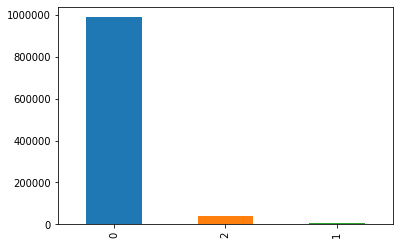

In [38]:
#lets examine how many diabetes and non diabetes there are
# 0 is non, 1 is type 1, 2 is type2
diabetes_df['Type'].value_counts().plot.bar()

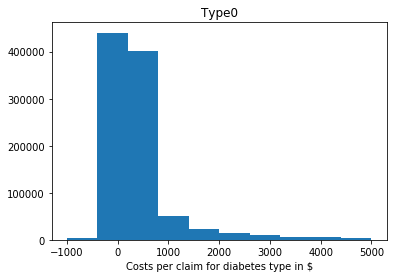

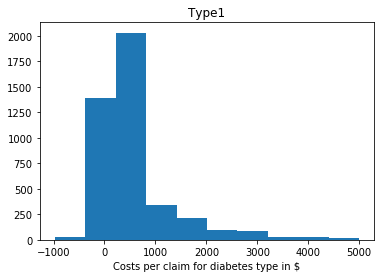

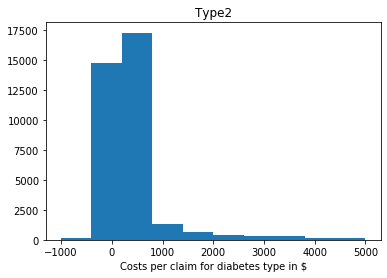

In [74]:
#plot distributions of total costs for each type
type_df = [0,1,2]
for eek in type_df:
    #subset
    frame = diabetes_df[diabetes_df["Type"] == eek]
    costs = frame['Total_Costs_Per_Claim']
    #limit
    upper_bound = 5000
    lower_bound = -1000
    index = (costs <= upper_bound) & (costs >=lower_bound)
    costs = costs[index]
    plt.hist(costs)
    plt.xlabel('Costs per claim for diabetes type in $')
    plt.title('Type'+str(eek))
    plt.show()

### b)	What was the total cost of Diabetes in 2016 and 2017 separately for those covered through private insurance? Extrapolate your answer by including the fact that you have approx. 7% of all the claims.

In [89]:
index = (diabetes_df['Type'].isin([1,2])) & (diabetes_df['Insurance'] == "COMMERCIAL")
years = [2016,2017]
for year in years:
    frame = diabetes_df[index][['Year','Total_Costs_Per_Claim']]
    #get totals for year
    totals = frame[frame['Year'] == year]['Total_Costs_Per_Claim']
    totals = sum(totals)
    #extrapolate
    ext_total = totals/.07
    print('Total for ',year,'is ',totals,'. Extrapolated total is ', ext_total)



Total for  2016 is  35362539.31999969 . Extrapolated total is  505179133.1428526
Total for  2017 is  43142043.809999295 . Extrapolated total is  616314911.5714184


### c)Submit a table of average Billed Amounts by county for years 2016 and 2017 for all diabetes related cases. Identify the county with the biggest difference in the average cost over the two years

In [108]:
index = (diabetes_df['Type'].isin([1,2]))
county_year = diabetes_df[index][['Year','County',
                    'Total_Costs_Per_Claim']].groupby([
    'County','Year']).agg([np.sum,np.mean,len])
county_year.reset_index(inplace=True)
county_year.head()

                                                                                                                                                                                                                                  

County  Year Total_Costs_Per_Claim                     
                                 sum         mean     len
0      1  2016            2298370.35  1818.330973  1264.0
1      1  2017            2566682.05  2121.224835  1210.0
2      3  2016            2175483.66  3034.147364   717.0
3      3  2017            1920056.30  2584.194213   743.0
4      5  2016            1028938.77   944.847355  1089.0

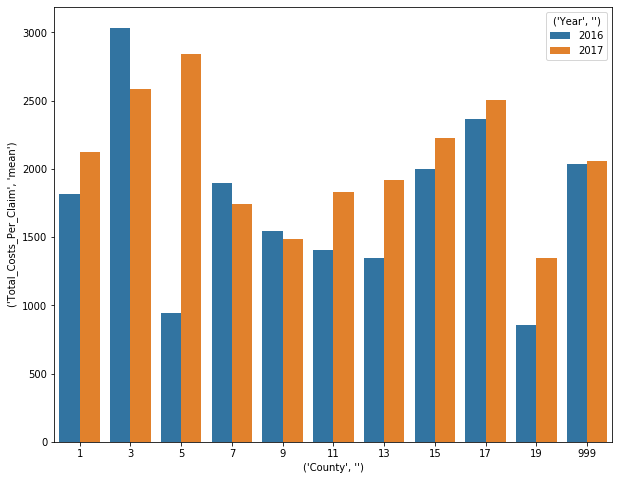

In [114]:
plt.figure(figsize=(10,8))
sns.barplot(x=('County', ''), y=('Total_Costs_Per_Claim', 'mean'), 
            hue=('Year', ''), data=county_year)

### Part 2
### What were the two most commonly used procedures (name and definition) for males and females for Hillsborough County for those suffering from Diabetes in years 2016 and 2017?

* Hillsborough county is 11
* for each pair of male female by year, pull from proc list
* add each proc, and find the counts of each

In [153]:
#define function that compiles from a list of lists
import json
def compile(list1):
    output = []
    '''
    input is a list of lists
    '''
    for i in range(0,len(list1)):
        #traverse elemnts in list
        for j in range(0,len(list1[i])):
            output.append(list1[i][j])
    frame = pd.DataFrame()
    frame['test'] = output
    output = frame['test'].value_counts()
    output = output[0:2]
    '''
    output = np.unique(output,return_counts=True)
    #pull top two codes and counts
    codes = list(output[0][0:2])
    counts = list(output[1][0:2])
    output_frame = pd.DataFrame()
    output_frame['Code'] = codes
    output_frame['Counts'] = counts
    '''
    return(output)
            

In [154]:
index = (diabetes_df['Type'].isin([1,2])) & (diabetes_df['County'] == 11)
genders = ['M','F']
years = [2016,2017]
diabetes_df[index][['Gender','Year','Procs_Per_Claim']]
for a in genders:
    for b in years:
        #frame to search
        frame = diabetes_df[index][['Gender','Year','Procs_Per_Claim']]
        search_index = (frame['Gender'] == a) & (frame['Year'] == b)
        frame = frame[search_index]
        print('Gender is ',a,'and year is ', b)
        print(compile(list(frame['Procs_Per_Claim'])))

Gender is  M and year is  2016
99214    605
83036    553
Name: test, dtype: int64
Gender is  M and year is  2017
99214    642
83036    582
Name: test, dtype: int64
Gender is  F and year is  2016
99214    508
83036    372
Name: test, dtype: int64
Gender is  F and year is  2017
99214    479
83036    390
Name: test, dtype: int64


# 2. create a table of the average billed amounts for the below procedures by county

* chunk throough dat file
* for each chunk, limit search
* only grab lines that are in the codes
* for each match, create flag vars
* stack smaller frames together
* use groupy on the stacked one

In [239]:
import warnings
warnings.filterwarnings('ignore')
size = 300000
X_knees_toes =[73500,73501,73502,73503,73510,73520,73521,
             73522,73523,73525,73530,73540,73542,73550,73551,
             73552,73560,73562,73564,73565,73580,73590, 73592, 
             73600, 73610, 73615, 73620, 73630, 73650, 73660]
MRI_chest = [71550,71551,71552,71555]
X_chest = [71010, 71015, 71020, 71021, 71022, 71023, 71030, 71034, 71035]
CT_brain = [70450, 70460, 70470]

#convert to strings

X_knees_toes = [str(x) for x in X_knees_toes]
MRI_chest = [str(x) for x in MRI_chest]
X_chest = [str(x) for x in X_chest]
CT_brain = [str(x) for x in CT_brain]

frames = []

for idx,chunk in enumerate(pd.read_csv('SampleClaims1617.dat',chunksize = size)):
    print(idx,'th chunk processed at',time.ctime())
    #grab the right ones to search
    frame_to_search = chunk[['MEMBER_COUNTY','PROC_CODE','AMT_BILLED']]
    #create flag column
    flag = []
    #reset index before search
    frame_to_search.reset_index(inplace=True)
    frame_to_search.fillna(0,inplace=True)
    for i in range(0,frame_to_search.shape[0]):
        if i == frame_to_search.shape[0]-1:
            print("finished searching first chunk",time.ctime())
        code = frame_to_search['PROC_CODE'][i]
        #now check conditions
        if code in X_knees_toes:
            flag.append('X_ray_kft')
        elif code in MRI_chest:
            flag.append('MRI_chest')
        elif code in X_chest:
            flag.append("X_Ray_chest")
        elif code in CT_brain:
            flag.append("CT_brain")
        else:
            flag.append(0)
    #put flag back as column
    frame_to_search['Type'] = flag
    #filter out where type is not zero
    index = frame_to_search['Type'] != 0
    frame_to_search = frame_to_search[index]
    frames.append(frame_to_search)


0 th chunk processed at Sun Nov 24 17:20:09 2019
finished searching first chunk Sun Nov 24 17:20:14 2019
1 th chunk processed at Sun Nov 24 17:20:17 2019
finished searching first chunk Sun Nov 24 17:20:21 2019
2 th chunk processed at Sun Nov 24 17:20:24 2019
finished searching first chunk Sun Nov 24 17:20:29 2019
3 th chunk processed at Sun Nov 24 17:20:31 2019
finished searching first chunk Sun Nov 24 17:20:36 2019
4 th chunk processed at Sun Nov 24 17:20:39 2019
finished searching first chunk Sun Nov 24 17:20:43 2019
5 th chunk processed at Sun Nov 24 17:20:46 2019
finished searching first chunk Sun Nov 24 17:20:51 2019
6 th chunk processed at Sun Nov 24 17:20:53 2019
finished searching first chunk Sun Nov 24 17:20:58 2019
7 th chunk processed at Sun Nov 24 17:21:01 2019
finished searching first chunk Sun Nov 24 17:21:06 2019
8 th chunk processed at Sun Nov 24 17:21:07 2019
finished searching first chunk Sun Nov 24 17:21:09 2019


In [240]:
for i in range(0,len(frames)):
    print(frames[i]['Type'].value_counts())

X_Ray_chest    2479
X_ray_kft      2142
CT_brain        634
MRI_chest         7
Name: Type, dtype: int64
X_ray_kft      2868
X_Ray_chest    2442
CT_brain        468
MRI_chest         9
Name: Type, dtype: int64
X_ray_kft      3042
X_Ray_chest    2717
CT_brain        542
MRI_chest        14
Name: Type, dtype: int64
X_Ray_chest    3119
X_ray_kft      2623
CT_brain        730
MRI_chest         6
Name: Type, dtype: int64
X_ray_kft      2463
X_Ray_chest    2109
CT_brain        439
MRI_chest         8
Name: Type, dtype: int64
X_ray_kft      3235
X_Ray_chest    2803
CT_brain        546
MRI_chest         2
Name: Type, dtype: int64
X_ray_kft      2948
X_Ray_chest    2943
CT_brain        645
MRI_chest         8
Name: Type, dtype: int64
X_Ray_chest    2870
X_ray_kft      2163
CT_brain        789
MRI_chest         4
Name: Type, dtype: int64
X_Ray_chest    259
X_ray_kft      180
CT_brain        71
Name: Type, dtype: int64


In [244]:
#put the frames together
X_ray_MRI_df = pd.concat(frames)
X_ray_MRI_df.to_csv('x_ray_mri.csv')
X_ray_MRI_df.head()

,index,MEMBER_COUNTY,PROC_CODE,AMT_BILLED,Type
159,159,11,73560,395.25,X_ray_kft
160,160,11,73562,607.00,X_ray_kft
274,274,9,71010,404.00,X_Ray_chest
312,312,13,73564,512.00,X_ray_kft
321,321,11,73610,269.00,X_ray_kft


In [247]:
#groupby
X_ray_MRI_df[['MEMBER_COUNTY','PROC_CODE','AMT_BILLED']].groupby(['MEMBER_COUNTY',
                            'PROC_CODE']).agg([np.sum,np.mean,len])

AMT_BILLED                     
                               sum         mean     len
MEMBER_COUNTY PROC_CODE                                
1             70450      198475.08   666.023758   298.0
              70460        1629.00  1629.000000     1.0
              70470        2904.38   580.876000     5.0
              71010       45638.86    91.460641   499.0
              71020      100764.40   125.173168   805.0
              71022         222.00   222.000000     1.0
              71035          32.00    32.000000     1.0
              71550        6996.00  3498.000000     2.0
              71552         817.00   817.000000     1.0
              71555        3946.00  3946.000000     1.0
              73501        1183.00   131.444444     9.0
              73502       25008.33   126.945838   197.0
              73503          53.00    53.000000     1.0
              73521        3694.78   246.318667    15.0
              73522        1858.00   168.909091    11.0
              73523        1375.00   171.875000     8.0
              73525        4554.00   650.571429     7.0
              73551         157.00   157.000000     1.0
              73552        4408.00   157.428571    28.0
              73560       13295.65   115.614348   115.0
              73562       30690.30   117.587356   261.0
              73564       16354.78   185.849773    88.0
              73565        7528.00   101.729730    74.0
              73590        5474.00    97.750000    56.0
              73600         692.00    69.200000    10.0
              73610       19982.24   108.012108   185.0
              73620        1324.05    88.270000    15.0
              73630       23842.81   103.215628   231.0
              73650        1957.50    97.875000    20.0
              73660        1868.32   109.901176    17.0
3             70450      139188.55   702.972475   198.0
              70460         448.00   224.000000     2.0
              70470         500.00   250.000000     2.0
              71010       29340.98   115.515669   254.0
              71020       99317.45   160.189435   620.0
              71023         974.50   487.250000     2.0
              71035          37.00    37.000000     1.0
              71552        7092.00  2364.000000     3.0
              71555        2369.46  1184.730000     2.0
              73501        1677.00   119.785714    14.0
              73502       15976.88   119.230448   134.0
              73503         366.00   183.000000     2.0
              73521        1131.50   141.437500     8.0
              73522        2208.00   245.333333     9.0
              73523        2861.00   220.076923    13.0
              73525         577.00   577.000000     1.0
              73552        1259.00   125.900000    10.0
              73560       13267.55   113.397863   117.0
              73562       20364.67   120.501006   169.0
              73564       15724.52   187.196667    84.0
              73565        2186.00   115.052632    19.0
              73590        4602.20   127.838889    36.0
              73600        1251.50    78.218750    16.0
              73610       12938.80   116.565766   111.0
              73620        1104.87    78.919286    14.0
              73630       29428.62   150.916000   195.0
              73650        1387.00   115.583333    12.0
              73660        1564.00    78.200000    20.0
5             70450      142935.75   629.672907   227.0
              70460         251.00   251.000000     1.0
              70470        8124.00  1354.000000     6.0
              71010       22222.98    97.898590   227.0
              71020      148116.93   172.630455   858.0
              71035         262.00    65.500000     4.0
              71552        5711.59  5711.590000     1.0
              73501        2604.00   260.400000    10.0
              73502       36784.51   215.114094   171.0
              73503         241.00   241.000000     1.0
              73521        1407.87   117.322500 

In [249]:
X_ray_MRI_df[['MEMBER_COUNTY','Type','AMT_BILLED']].groupby(['MEMBER_COUNTY',
                            'Type']).agg([np.sum,np.mean,len])

AMT_BILLED                     
                                 sum         mean     len
MEMBER_COUNTY Type                                       
1             CT_brain     203008.46   667.790987   304.0
              MRI_chest     11759.00  2939.750000     4.0
              X_Ray_chest  146657.26   112.294992  1306.0
              X_ray_kft    165300.76   122.535775  1349.0
3             CT_brain     140136.55   693.745297   202.0
              MRI_chest      9461.46  1892.292000     5.0
              X_Ray_chest  129669.93   147.856249   877.0
              X_ray_kft    129876.11   131.987917   984.0
5             CT_brain     151310.75   646.627137   234.0
              MRI_chest      5711.59  5711.590000     1.0
              X_Ray_chest  170601.91   156.659238  1089.0
              X_ray_kft    253171.02   204.334964  1239.0
7             CT_brain      79214.77   747.309151   106.0
              X_Ray_chest   60536.06   125.593485   482.0
              X_ray_kft     88863.87   145.678475   610.0
9             CT_brain     203543.46   827.412439   246.0
              MRI_chest      6652.00  6652.000000     1.0
              X_Ray_chest  177180.31   150.025665  1181.0
              X_ray_kft    255430.26   192.487008  1327.0
11            CT_brain     958537.46   744.206102  1288.0
              MRI_chest     44476.00  2470.888889    18.0
              X_Ray_chest  819634.73   143.367978  5717.0
              X_ray_kft    944788.74   176.629041  5349.0
13            CT_brain     468247.78   856.028848   547.0
              MRI_chest     10936.00  1367.000000     8.0
              X_Ray_chest  315124.08   144.155572  2186.0
              X_ray_kft    401683.52   154.791337  2595.0
15            CT_brain     906741.96   912.215252   994.0
              MRI_chest     11017.66  1001.605455    11.0
              X_Ray_chest  663893.04   145.942634  4549.0
              X_ray_kft    645822.35   156.638940  4123.0
17            CT_brain     400738.15  1175.185191   341.0
              MRI_chest      4803.00  2401.500000     2.0
              X_Ray_chest  286851.72   183.643867  1562.0
              X_ray_kft    205168.07   153.110500  1340.0
19            CT_brain      70456.16   718.940408    98.0
              X_Ray_chest   77778.66   147.587590   527.0
              X_ray_kft    115273.39   189.906738   607.0
999           CT_brain     401501.67   796.630298   504.0
              MRI_chest     19303.00  2412.875000     8.0
              X_Ray_chest  315257.50   139.186534  2265.0
              X_ray_kft    337652.73   157.707954  2141.0

# 3. Create a flag for brain injuries based on the list of ICD codes provided with the assignment documents.

* Same method as in the first part, just change the matching ICD codes

# Created code patterns to search

In [4]:
short_ones = ['T71','I60','I62','I63','I67','I69','Z87',
              'Z85','Z96','O74','O89','P84','G93','G03',
             'G06','G08','G09','G30','G31','G32','G92','G93']
long_ones1 = ["T"+str(X) for X in range(51,66)]
long_ones2 = ["S0"+str(X) for X in range(0,10)]
brain_codes = short_ones + long_ones1 + long_ones2

In [5]:
brain = set()
for eek in range(0,ICD10.shape[0]):
    #pull line items
    line = ICD10.iloc[eek,:]
    code = line[0]
    code_search = code[0:3]
    if code_search in brain_codes:
        #add code to set
        brain.add(code)
    else:
        pass

In [6]:
len(brain)

4245

### In this case, the methdology for the first part would take way too long. Since there are 4245 codes to match on, and the ICD list to search from is 12, the time complexity would be $O(10000\times4245\times12)$. Compared to the first part which was $O(100000\times109\times12)$. In this case, it would take 4245/109 times longer....I need a new way to match strings using only one loop...

lets define a function:

* well take the list of ICD codes
* traverse each code in the list
* if the code is in brain, add counter 1
* else pass
* if the counter is greater than 0, then were was at least a match
* append to flag column

In [18]:
def check_if_in(list_to_search, ifin):
    counter = 0
    for i in range(0,len(list_to_search)):
        if list_to_search[i] in ifin:
            counter += 1
    else:
        pass
    return(counter)

In [19]:
import warnings
warnings.filterwarnings('ignore')
size = 200000
dict1 = dict()

for idx,chunk in enumerate(pd.read_csv('SampleClaims1617.dat',chunksize = size)):
    print(idx,'th chunk processed at',time.ctime())
    #grab col names
    ICD_cols = [col for col in list(chunk.columns) if 'ICD' in col]
    #search frame,create flag history
    flag = []
    frame_to_search = chunk[ICD_cols]
    #reset index before search
    frame_to_search.reset_index(inplace=True)
    for i in range(0,frame_to_search.shape[0]):
        if i == frame_to_search.shape[0]-1:
            print('finished searching ',idx,'th chunk ',time.ctime())
        #pull line items
        lines = list(frame_to_search.iloc[i,:])
        #check if brain code
        if check_if_in(lines,brain) > 0:
            flag.append(1)
        else:
            flag.append(0)
    #add flag history as new column
    chunk['Brain'] = flag
    #reset index on chunk
    chunk.reset_index(inplace=True)
    #search updated frame
    for j in range(0,chunk.shape[0]):
        if j== chunk.shape[0]-1:
            print('finished updating claim dict',time.ctime())
        #grab elements
        claim_ID = chunk['CLAIM_ID_KEY'][j]
        type_diabetes = chunk['Brain'][j]
        amount_billed = chunk['AMT_BILLED'][j]
        amount_paid = chunk['AMT_PAID'][j]
        year = chunk['FROM_YEAR'][j]
        gender = chunk['SEX'][j]
        age = chunk['AGE'][j]
        county = chunk['MEMBER_COUNTY'][j]
        insurace = chunk['LOB'][j]
        procedure = chunk['PROC_CODE'][j]
        key = (claim_ID,type_diabetes,year,gender,age,county,insurace)
        #value ias billed amount,paid, and proc code
        #note, this time value will be lists of lists, and final nested listed will have three elements
        #pull apart later
        value = [amount_billed,amount_paid,procedure]
        #adding to dict
        if key not in dict1:
            dict1[key] = [value]
        else:
            if key in dict1:
                #append
                current_list = dict1[key]
                current_list.append(value)
                dict1[key] = current_list

# Save
np.save('brain_1_no.npy', dict1)

0 th chunk processed at Tue Nov 26 00:27:11 2019
finished searching  0 th chunk  Tue Nov 26 00:27:40 2019
finished updating claim dict Tue Nov 26 00:27:59 2019
1 th chunk processed at Tue Nov 26 00:28:00 2019
finished searching  1 th chunk  Tue Nov 26 00:28:30 2019
finished updating claim dict Tue Nov 26 00:28:49 2019
2 th chunk processed at Tue Nov 26 00:28:50 2019
finished searching  2 th chunk  Tue Nov 26 00:29:20 2019
finished updating claim dict Tue Nov 26 00:29:39 2019
3 th chunk processed at Tue Nov 26 00:29:40 2019
finished searching  3 th chunk  Tue Nov 26 00:30:10 2019
finished updating claim dict Tue Nov 26 00:30:29 2019
4 th chunk processed at Tue Nov 26 00:30:31 2019
finished searching  4 th chunk  Tue Nov 26 00:31:01 2019
finished updating claim dict Tue Nov 26 00:31:20 2019
5 th chunk processed at Tue Nov 26 00:31:21 2019
finished searching  5 th chunk  Tue Nov 26 00:31:50 2019
finished updating claim dict Tue Nov 26 00:32:08 2019
6 th chunk processed at Tue Nov 26 00:32

In [25]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(1000, dict1)
n_items

[(262515431, 0, 2016, 'F', '47', 11, 'COMMERCIAL'),
 (262516483, 0, 2016, 'F', '13', 11, 'COMMERCIAL'),
 (262516512, 0, 2016, 'F', '61', 15, 'COMMERCIAL'),
 (118126990, 0, 2016, 'F', '61', 11, 'COMMERCIAL'),
 (262517461, 0, 2016, 'F', '27', 19, 'COMMERCIAL'),
 (118127329, 0, 2016, 'M', '0', 1, 'COMMERCIAL'),
 (118127681, 0, 2016, 'F', '20', 11, 'COMMERCIAL'),
 (118132567, 0, 2016, 'F', '49', 11, 'COMMERCIAL'),
 (118133142, 0, 2016, 'M', '0', 5, 'COMMERCIAL'),
 (262527496, 0, 2016, 'M', '51', 11, 'COMMERCIAL'),
 (262527518, 0, 2016, 'M', '44', 15, 'COMMERCIAL'),
 (262528448, 0, 2016, 'F', '28', 11, 'COMMERCIAL'),
 (262528553, 0, 2016, 'M', '64', 999, 'COMMERCIAL'),
 (118136830, 1, 2016, 'F', '29', 5, 'COMMERCIAL'),
 (118137806, 0, 2016, 'F', '61', 3, 'COMMERCIAL'),
 (262530720, 0, 2016, 'F', '60', 9, 'COMMERCIAL'),
 (262531914, 0, 2016, 'F', '48', 13, 'COMMERCIAL'),
 (118139699, 0, 2016, 'M', '52', 15, 'COMMERCIAL'),
 (262537859, 0, 2016, 'F', '25', 19, 'COMMERCIAL'),
 (262538070, 0, 20

In [27]:
#pull apart dictionary
ID = []
brain = []
year = []
gender = []
age = []
county = []
insurance = []
all_billed = []
all_paid = []
all_codes = []
for k,v in dict1.items():
    a = k[0]
    b = k[1]
    c = k[2]
    d = k[3]
    e = k[4]
    f = k[5]
    g = k[6]
    #traverse v
    billed = []
    paid = []
    code = []
    for i in range(0,len(v)):
        billed_to_grab = v[i][0]
        billed.append(billed_to_grab)
        paid_to_grab = v[i][1]
        paid.append(paid_to_grab)
        code_to_grab = v[i][2]
        code.append(code_to_grab)
    #add to lists for all
    ID.append(a)
    brain.append(b)
    year.append(c)
    gender.append(d)
    age.append(e)
    county.append(f)
    insurance.append(g)
    all_billed.append(billed)
    all_paid.append(paid)
    all_codes.append(code)

In [29]:
len(brain)

1030446

In [31]:
#put everything back into a dataframe
brain_df = pd.DataFrame()
brain_df['ID'] = ID
brain_df['Type'] = brain
brain_df['Year'] = year
brain_df['Gender'] = gender
brain_df['Age'] = age
brain_df['County'] = county
brain_df['Insurance'] = insurance
brain_df['Billed_Per_Claim'] = all_billed
brain_df['Total_Billed_Per_Claim'] = brain_df['Billed_Per_Claim'].apply(lambda x: sum(x))
brain_df['Paid_Per_claim'] = all_paid
brain_df['Total_Paid_Per_Claim'] = brain_df['Paid_Per_claim'].apply(lambda x: sum(x))
brain_df['Procs_Per_Claim'] = all_codes
brain_df.to_csv('brain_df_16_17.csv')
brain_df.head()

,ID,Type,Year,Gender,Age,County,Insurance,Billed_Per_Claim,Total_Billed_Per_Claim,Paid_Per_claim,Total_Paid_Per_Claim,Procs_Per_Claim
0,262515431,0,2016,F,47,11,COMMERCIAL,"[3.2, 171.04, 16.16, 300.66]",491.06,"[0.0, 118.31, 0.0, 0.0]",118.31,"[nan, 99212, nan, 97605]"
1,262516483,0,2016,F,13,11,COMMERCIAL,"[48.51, 97.02, 70.82]",216.35,"[25.9, 51.8, 28.87]",106.57,"[87147, 87147, 87081]"
2,262516512,0,2016,F,61,15,COMMERCIAL,"[8.34, 28.71, 146.5, 93.14, 138.23, 229.66, 18...",1610.66,"[0.0, 0.0, 0.0, 0.0, 0.0, 105.75, 48.42, 224.2...",378.46,"[nan, 36415, 80053, 83735, 85025, 96374, 96375..."
3,118126990,0,2016,F,61,11,COMMERCIAL,"[107.65, 1643.0, 23684.0, 33642.65, 4070.0, 90...",93525.30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",24505.94,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
4,262517461,0,2016,F,27,19,COMMERCIAL,"[42.91, 15.64, 65.78, 133.07, 95.09]",352.49,"[5.4, 3.36, 6.89, 18.42, 8.65]",42.72,"[85651, 36415, 84550, 86038, 86431]"


### How many claims, related to brain?

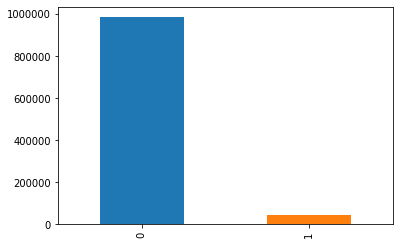

In [34]:
brain_df['Type'].value_counts().plot.bar()

# Challenge Problem 1 of 2:
#### Create a count matrix showing the counts for each pair of ICD codes
#### I.E the i,j element are the counts for each pair of comorbidities
#### imagine the case if these were 3,4,5...n pairs

In [9]:
import warnings
warnings.filterwarnings('ignore')
size = 300000
dict1 = dict()

for idx,chunk in enumerate(pd.read_csv('SampleClaims1617.dat',chunksize = size)):
    print(idx,'th chunk processed at',time.ctime())
    #grab col names
    ICD_cols = [col for col in list(chunk.columns) if 'ICD' in col]
    #remove some
    ICD_cols.remove('ICD_10_OR_HIGHER')
    ICD_cols.remove('')
    #initialize grouping ICDS
    grouping_ICDS = []
    #first search through ICD colmns
    frame_to_search = chunk[ICD_cols]
    #reset index before search
    frame_to_search.reset_index(inplace=True)
    for i in range(0,frame_to_search.shape[0]):
        if i == frame_to_search.shape[0]-1:
            print('finished first search in ',idx,'th chunk ',time.ctime())
        #pull line items
        lines = list(frame_to_search.iloc[i,:])
        #add to grouping ICDS
        grouping_ICDS.append(lines)
    #adding grouping ICDS as new column
    chunk['ICDS_GROUPED'] = grouping_ICDS
    #reset index on chunk
    chunk.reset_index(inplace=True)
    #search updated frame
    for j in range(0,chunk.shape[0]):
        if j== chunk.shape[0]-1:
            print('finished updating claim dict',time.ctime())
        #grab elements
        claim_ID = chunk['CLAIM_ID_KEY'][j]
        year = chunk['FROM_YEAR'][j]
        gender = chunk['SEX'][j]
        age = chunk['AGE'][j]
        county = chunk['MEMBER_COUNTY'][j]
        insurace = chunk['LOB'][j]
        ICDS = chunk['ICDS_GROUPED'][j]
        key = (claim_ID,year,gender,age,county,insurace)
        #value ias billed amount,paid, and proc code
        #note, this time value will be lists of lists, and final nested listed will have three elements
        #pull apart later
        value = ICDS
        #adding to dict
        if key not in dict1:
            dict1[key] = value
        else:
            if key in dict1:
                #overwrite
                dict1[key] = value

# Save
np.save('ICDS.npy', dict1)

0 th chunk processed at Sun Dec  1 23:32:31 2019
finished first search in  0 th chunk  Sun Dec  1 23:33:16 2019
finished updating claim dict Sun Dec  1 23:33:37 2019
1 th chunk processed at Sun Dec  1 23:33:38 2019
finished first search in  1 th chunk  Sun Dec  1 23:34:27 2019
finished updating claim dict Sun Dec  1 23:34:50 2019
2 th chunk processed at Sun Dec  1 23:34:51 2019
finished first search in  2 th chunk  Sun Dec  1 23:35:38 2019
finished updating claim dict Sun Dec  1 23:36:00 2019
3 th chunk processed at Sun Dec  1 23:36:01 2019
finished first search in  3 th chunk  Sun Dec  1 23:36:45 2019
finished updating claim dict Sun Dec  1 23:37:05 2019
4 th chunk processed at Sun Dec  1 23:37:07 2019
finished first search in  4 th chunk  Sun Dec  1 23:37:51 2019
finished updating claim dict Sun Dec  1 23:38:11 2019
5 th chunk processed at Sun Dec  1 23:38:13 2019
finished first search in  5 th chunk  Sun Dec  1 23:38:55 2019
finished updating claim dict Sun Dec  1 23:39:16 2019
6 th

# Note, must load in dictionary first

In [2]:
# Load
dict1 = np.load('ICDS.npy',allow_pickle='TRUE').item()

In [3]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

n_items = take(5, dict1.items())
n_items


[((262515431, 2016, 'F', '47', 11, 'COMMERCIAL'),
  [3,
   nan,
   'T8189XD',
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]),
 ((262516483, 2016, 'F', '13', 11, 'COMMERCIAL'),
  [6,
   nan,
   'J029',
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]),
 ((262516512, 2016, 'F', '61', 15, 'COMMERCIAL'),
  [17,
   nan,
   'R42',
   nan,
   'F0781',
   'R110',
   'I10',
   'G43909',
   'Z79899',
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan]),
 ((118126990, 2016, 'F', '61', 11, 'COMMERCIAL'),
  [152495,
   '07TM',
   'D150',
   'R222',
   'R222',
   'I421',
   'C50919',
   'E785',
   'F329',
   'F419',
   'I10',
   'Z9049',
   'Z880',
   'Z90710',
   'I080',
   nan]),
 ((262517461, 2016, 'F', '27', 19, 'COMMERCIAL'),
  [26,
   nan,
   'M2550',
   nan,
   'L639',
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan,
   nan])]

In [4]:
#pull apart dictionary
ID = []
year = []
gender = []
age = []
county = []
insurance = []
ICDS = []
for k,v in dict1.items():
    ID.append(k[0])
    year.append(k[1])
    gender.append(k[2])
    age.append(k[3])
    county.append(k[4])
    insurance.append(k[5])
    ICDS.append(v)


### Cleaning

In [5]:
#make into a dataframe
ICDS_df = pd.DataFrame()
ICDS_df['ID'] = ID
ICDS_df['Year'] = year
ICDS_df['Gender'] = gender
ICDS_df['Age'] = age
ICDS_df['County'] = county
ICDS_df['Insurance'] = insurance
ICDS_df['ICDS'] = ICDS
ICDS_df.to_csv("ICDS_df.csv")

In [6]:
#remove fist element in ICDS column
ICDS_df['ICDS_2'] = ICDS_df['ICDS'].apply(lambda x:x[1:])

In [7]:
ICDS_df.head()

,ID,Year,Gender,Age,County,Insurance,ICDS,ICDS_2
0,262515431,2016,F,47,11,COMMERCIAL,"[3, nan, T8189XD, nan, nan, nan, nan, nan, nan...","[nan, T8189XD, nan, nan, nan, nan, nan, nan, n..."
1,262516483,2016,F,13,11,COMMERCIAL,"[6, nan, J029, nan, nan, nan, nan, nan, nan, n...","[nan, J029, nan, nan, nan, nan, nan, nan, nan,..."
2,262516512,2016,F,61,15,COMMERCIAL,"[17, nan, R42, nan, F0781, R110, I10, G43909, ...","[nan, R42, nan, F0781, R110, I10, G43909, Z798..."
3,118126990,2016,F,61,11,COMMERCIAL,"[152495, 07TM, D150, R222, R222, I421, C50919,...","[07TM, D150, R222, R222, I421, C50919, E785, F..."
4,262517461,2016,F,27,19,COMMERCIAL,"[26, nan, M2550, nan, L639, nan, nan, nan, nan...","[nan, M2550, nan, L639, nan, nan, nan, nan, na..."


In [8]:
#grab codes not nan
ICDS_df['ICDS_2'][0][0] is np.nan
def pull_not_nulls(list1):
    not_nulls = []
    for i in range(0,len(list1)):
        if str(list1[i]) == 'nan':
            pass
        else:
            not_nulls.append(list1[i])
    not_nulls = [str(i) for i in not_nulls]
    return(not_nulls)

pull_not_nulls(ICDS_df['ICDS_2'][0])
ICDS_df['ICDS_3'] = ICDS_df["ICDS_2"].apply(pull_not_nulls)

In [9]:
ICDS_df.head()

,ID,Year,Gender,Age,County,Insurance,ICDS,ICDS_2,ICDS_3
0,262515431,2016,F,47,11,COMMERCIAL,"[3, nan, T8189XD, nan, nan, nan, nan, nan, nan...","[nan, T8189XD, nan, nan, nan, nan, nan, nan, n...",[T8189XD]
1,262516483,2016,F,13,11,COMMERCIAL,"[6, nan, J029, nan, nan, nan, nan, nan, nan, n...","[nan, J029, nan, nan, nan, nan, nan, nan, nan,...",[J029]
2,262516512,2016,F,61,15,COMMERCIAL,"[17, nan, R42, nan, F0781, R110, I10, G43909, ...","[nan, R42, nan, F0781, R110, I10, G43909, Z798...","[R42, F0781, R110, I10, G43909, Z79899]"
3,118126990,2016,F,61,11,COMMERCIAL,"[152495, 07TM, D150, R222, R222, I421, C50919,...","[07TM, D150, R222, R222, I421, C50919, E785, F...","[07TM, D150, R222, R222, I421, C50919, E785, F..."
4,262517461,2016,F,27,19,COMMERCIAL,"[26, nan, M2550, nan, L639, nan, nan, nan, nan...","[nan, M2550, nan, L639, nan, nan, nan, nan, na...","[M2550, L639]"


In [10]:
#use itertools and flatten
import itertools
flatten = itertools.chain.from_iterable
to_search = list(ICDS_df['ICDS_3'])
codes = list(flatten(to_search))

In [11]:
print(len(codes))
codes = list(set(codes))
print(len(codes))

2257666
23355


In [12]:
codes

['G43901',
 'J95830',
 'M25641',
 'B250',
 'M87274',
 'S41101D',
 'S00211A',
 '0210',
 'Y289XXA',
 'Q333',
 'R402332',
 'B4481',
 'K2951',
 'S8254XD',
 'S32402A',
 'E113512',
 'N6321',
 'W900XXS',
 'W090XXA',
 'S4361XA',
 'H439',
 'S46819D',
 'Z192',
 '0SRD0JA',
 'T528X1A',
 '0WQN',
 'H401190',
 'S62114A',
 'S83402A',
 'H15832',
 'E7871',
 'F428',
 'F641',
 'I69312',
 'S83251D',
 'S86192A',
 'S88129A',
 'M2190',
 'E638',
 'S61052A',
 'I75029',
 'S72115A',
 'O2623',
 '0BTC4ZZ',
 'S92001S',
 'O4412',
 'C9312',
 'D234',
 '3E0F',
 'T23331A',
 'T880XXA',
 'M06221',
 'K267',
 'C9210',
 'H663X1',
 'M66822',
 'F1620',
 'S36430A',
 'M41116',
 'V639XXA',
 'A858',
 'Y904',
 'S329XXD',
 'M25432',
 'F10920',
 'S238XXD',
 'Q900',
 'H401491',
 'O669',
 'H3022',
 'C187',
 'M89541',
 '22554.0',
 'J156',
 'C008',
 'R4589',
 'M10372',
 'B91',
 'H02529',
 'S2242XB',
 'L97511',
 'S59802A',
 'E59',
 'M06061',
 'M7752',
 'Q6650',
 'F324',
 'R6521',
 'A89',
 '0NB00ZZ',
 'S56011A',
 'E46',
 'L041',
 'S025XXA',

# Apply count vectorizer instead

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
def dummy(doc):
    return doc

cv = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
)  


cv.fit(list(ICDS_df['ICDS_3']))
cv.get_feature_names()

['0.0',
 '000',
 '0000',
 '0000000',
 '0016',
 '00160J6',
 '00163JB',
 '00520ZZ',
 '0090',
 '009000Z',
 '00903ZX',
 '0094',
 '009400Z',
 '00943ZZ',
 '009600Z',
 '009630Z',
 '009730Z',
 '009T3ZZ',
 '009U',
 '009U3ZX',
 '009U3ZZ',
 '009Y',
 '009Y3ZX',
 '009Y40Z',
 '00B0',
 '00B00ZZ',
 '00B1',
 '00B10ZZ',
 '00B2',
 '00B6',
 '00B7',
 '00B70ZZ',
 '00B73ZX',
 '00BC0ZZ',
 '00BN',
 '00BN0ZZ',
 '00BT',
 '00BX0ZZ',
 '00BY',
 '00C3',
 '00C4',
 '00C40ZZ',
 '00CC',
 '00HV3MZ',
 '00NK',
 '00NK0ZZ',
 '00NM',
 '00NW0ZZ',
 '00NY0ZZ',
 '00P60JZ',
 '00QF0ZZ',
 '00U107Z',
 '00W6',
 '01',
 '0120',
 '0124',
 '0126',
 '0128',
 '0129',
 '015B',
 '015B3ZZ',
 '01B60ZZ',
 '01N10ZZ',
 '01N30ZZ',
 '01NB',
 '01NB0ZZ',
 '01NB3ZZ',
 '01Q5',
 '01Q50ZZ',
 '0210',
 '021009W',
 '02100Z9',
 '0211',
 '021109W',
 '02110Z9',
 '0212',
 '0212093',
 '0212099',
 '021209W',
 '0213',
 '02563ZZ',
 '02573ZK',
 '0258',
 '02583ZZ',
 '02584ZZ',
 '0270',
 '027034Z',
 '027035Z',
 '027036Z',
 '02703DZ',
 '02703ZZ',
 '0271',
 '027134Z',
 '

In [15]:
X = cv.fit_transform(list(ICDS_df['ICDS_3']))
print(type(X),X.shape)

<class 'scipy.sparse.csr.csr_matrix'> (1028085, 23355)


In [16]:
X_arr = X.toarray()

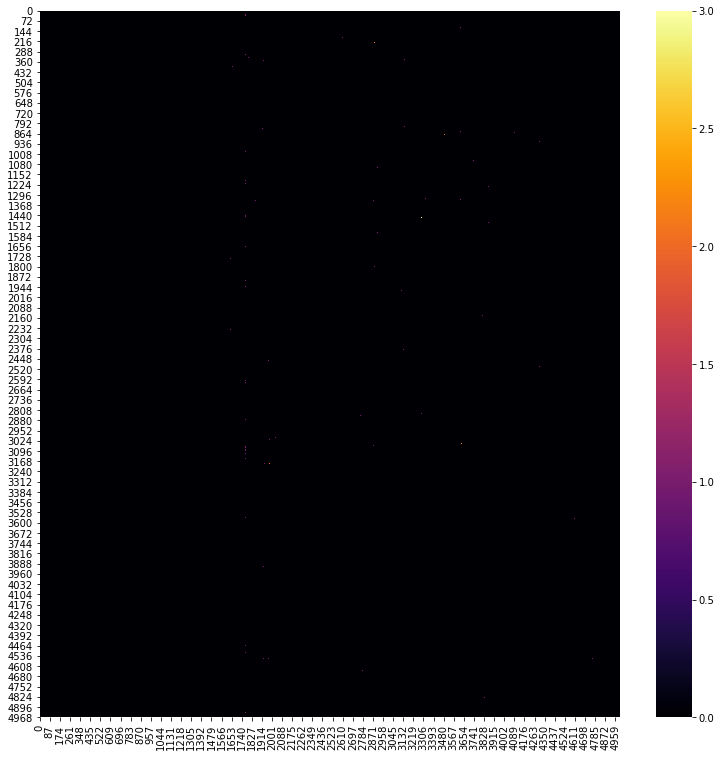

In [18]:
plt.figure(figsize=(13,13))
ax = sns.heatmap(X_arr[0:5000,5000:10000],cmap='inferno')
plt.show()

### Get counts of ICDS codes

In [16]:
import scipy.sparse
ICD_counts = X.sum(axis=0)
ICD_counts.shape

(1, 23355)

In [17]:
ICD_counts_df = pd.DataFrame()
ICD_counts_df['ICDS'] = codes
ICD_counts_df['Counts'] = ICD_counts.reshape((23355,1))
ICD_counts_df.sort_values('Counts',ascending=False).head(20)

,ICDS,Counts
6776,S2241XB,57718
22372,T373X5A,36011
22549,M069,29904
10585,T85840D,26495
3669,I63232,25014
3434,S5001XA,24106
11655,S86111D,22265
11653,D642,21617
4497,0T77,19806
10578,M65141,19515


### Get distribution of the number of ICDS per unique claim, entry

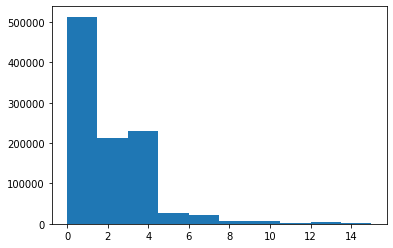

In [18]:
claim_counts_ICDS = X.sum(axis=1)
plt.hist(claim_counts_ICDS)
plt.show()

### Apply count vectorize, two bigrams
* find the instances where there are two
* pass the list into CountVectorizer
* can extend to n grams

In [20]:
ICDS_df['Length_ICDS'] = ICDS_df['ICDS_3'].apply(lambda x: len(x))
ICDS_df.head()


,ID,Year,Gender,Age,County,Insurance,ICDS,ICDS_2,ICDS_3,Length_ICDS
0,262515431,2016,F,47,11,COMMERCIAL,"[3, nan, T8189XD, nan, nan, nan, nan, nan, nan...","[nan, T8189XD, nan, nan, nan, nan, nan, nan, n...",[T8189XD],1
1,262516483,2016,F,13,11,COMMERCIAL,"[6, nan, J029, nan, nan, nan, nan, nan, nan, n...","[nan, J029, nan, nan, nan, nan, nan, nan, nan,...",[J029],1
2,262516512,2016,F,61,15,COMMERCIAL,"[17, nan, R42, nan, F0781, R110, I10, G43909, ...","[nan, R42, nan, F0781, R110, I10, G43909, Z798...","[R42, F0781, R110, I10, G43909, Z79899]",6
3,118126990,2016,F,61,11,COMMERCIAL,"[152495, 07TM, D150, R222, R222, I421, C50919,...","[07TM, D150, R222, R222, I421, C50919, E785, F...","[07TM, D150, R222, R222, I421, C50919, E785, F...",14
4,262517461,2016,F,27,19,COMMERCIAL,"[26, nan, M2550, nan, L639, nan, nan, nan, nan...","[nan, M2550, nan, L639, nan, nan, nan, nan, na...","[M2550, L639]",2


In [21]:
idx = ICDS_df['Length_ICDS'] == 2
sum(idx)

213206

In [22]:
def dummy(doc):
    return doc

cv1 = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(2,2),
    max_features=50000
)  


cv1.fit(ICDS_df[idx]['ICDS_3'])
print(len(cv1.get_feature_names()))

50000


In [ ]:
ICDS_df[idx]['ICDS_3'].value_counts()

In [ ]:
import scipy.sparse as sparse
plt.figure(figsize=(10,10))
plt.spy(X, markersize=.003)
plt.show()

### Function that does:
* builds row vector for each instance from df
* where elems in vectors are {0,1} yes or no for ICD


In [12]:
def create_row_counts(list_codes, ICDS):
    #initialize results
    results = np.zeros(len(ICDS))
    #search throuh list codes in ICDS
    for i in range(0,len(list_codes)):
        #get index
        index = ICDS.index(list_codes[i])
        #put 1 in results
        results[index] = 1
    return(results)
    

In [13]:
print(ICDS_df['ICDS_3'][44367])
print(sum(create_row_counts(ICDS_df["ICDS_3"][44367],codes)))

['C9100', 'D61811', 'Z452', 'I872']
4.0


In [37]:
#apply to the dataframe
row_results = []
to_search = ICDS_df['ICDS_3']
a = time.time()
for i in range(0,len(to_search)):
    row_results.append(create_row_counts(to_search[i],codes))
b = time.time()
print(b - a)

648.3503959178925


In [ ]:
claim_ICD_count = np.vstack(row_results)
claim_ICD_count.shape

In [36]:
((ICDS_df.shape[0] / 10000)*12)/60
#about 20 mins for this...
#im getting to the point where O(n^2) is biting me hard in the ass...

20.5617

In [35]:
np.vstack(row_results).shape

(10000, 23375)

In [21]:
print(len(row_results))
sum(row_results[99])

1000


1.0

In [53]:
codes = []
to_search = list(ICDS_df['ICDS_3'])[:50000]
for i in range(0,len(to_search)):
    if i == 0:
        a = time.time()
    if i == len(to_search) - 1:
        b = time.time()
    #update codes
    codes = codes + to_search[i]
print(b-a)
print(len(codes))

15.891899824142456
166302


In [54]:
a = time.time()
codes = sum(to_search, [])
b = time.time()
print(b-a)


14.332409858703613


In [55]:
import itertools
flatten = itertools.chain.from_iterable
a = time.time()
codes = list(flatten(to_search))
b = time.time()
print(b-a)

0.007892131805419922


In [57]:
codes[:100]

['T8189XD',
 'J029',
 'R42',
 'F0781',
 'R110',
 'I10',
 'G43909',
 'Z79899',
 '07TM',
 'D150',
 'R222',
 'R222',
 'I421',
 'C50919',
 'E785',
 'F329',
 'F419',
 'I10',
 'Z9049',
 'Z880',
 'Z90710',
 'I080',
 'M2550',
 'L639',
 '3E02',
 'Z3800',
 'Z3800',
 'Z3800',
 'Z23',
 '0VTT',
 'Z3800',
 'Z3800',
 'Z3800',
 'Z23',
 'T451X5A',
 'R509',
 'R509',
 'C50919',
 'E119',
 'D649',
 'I10',
 'F419',
 'Z3800',
 'Z3800',
 'Z3800',
 'Q541',
 'P545',
 'Z23',
 'Z008',
 'E790',
 'I120',
 'C20',
 'R5383',
 'K4090',
 'D176',
 'I10',
 'E119',
 'E785',
 '0RG1',
 'M5012',
 'M5012',
 'M5012',
 'J45909',
 'Z87891',
 'M069',
 'Z981',
 'C169',
 'C787',
 'Z66',
 'Z515',
 'E559',
 'Z0000',
 '0SRD',
 'M179',
 'M179',
 'M179',
 'E669',
 'I10',
 'E785',
 'E780',
 'L308',
 'F419',
 'Z9089',
 'K0500',
 'C641',
 'M1000',
 'Z0000',
 '0270',
 'I25110',
 'I214',
 'I214',
 'I214',
 'E785',
 'I10',
 'Z87891',
 'Z8249',
 'R7301',
 'Z3800',
 'Z3800',
 'Z3800']

In [26]:
len(set(codes))

11639

In [32]:
(77*13) / 60

16.683333333333334

In [35]:
a = []
b = ['asdfa','dsff','dsaf']
c = a+b
c


['asdfa', 'dsff', 'dsaf']

In [ ]:
#go through ICDS_3 and add to set
uniq_ICDS = set()
to_search = list(ICDS_df['ICDS_3'])
for i in range(0,len(to_search)):
    for j in range(0,len(to_search[i])):
        uniq_ICDS.add(to_search[i][j])
    


In [ ]:
#generate unique set of ICDS from this dataframe
uniq_ICDS = set()
to_search = list(ICDS_df['ICDS_2'])
for i in range(0,len(to_search)):


In [29]:
list(range(0,10))[1:]

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [23]:
test = pd.read_csv("SampleClaims1617.dat",nrows=500)
[col for col in list(test.columns) if 'ICD' in col]

['ICD_10_OR_HIGHER',
 'ICD_PROC_01_PRI',
 'ICD_DIAG_01_PRIMARY',
 'ICD_DIAG_ADMIT',
 'ICD_DIAG_02',
 'ICD_DIAG_03',
 'ICD_DIAG_04',
 'ICD_DIAG_05',
 'ICD_DIAG_06',
 'ICD_DIAG_07',
 'ICD_DIAG_08',
 'ICD_DIAG_09',
 'ICD_DIAG_10',
 'ICD_DIAG_11',
 'ICD_DIAG_12',
 'ICD_DIAG_13']

In [24]:
test.head()

,FROM_YEAR,CLAIM_ID_KEY,SERVICES_KEY,SV_LINE,FORM_TYPE,SV_STAT,POS,AGE,SEX,MEMBER_COUNTY,MEMBER_STATE,PRODUCT_TYPE,LOB,PROC_CODE,REV_CODE,ADM_SRC,ADM_TYPE,CLIENT_LOS,ICD_10_OR_HIGHER,ICD_PROC_01_PRI,ICD_DIAG_01_PRIMARY,ICD_DIAG_ADMIT,ICD_DIAG_02,ICD_DIAG_03,ICD_DIAG_04,ICD_DIAG_05,ICD_DIAG_06,ICD_DIAG_07,ICD_DIAG_08,ICD_DIAG_09,ICD_DIAG_10,ICD_DIAG_11,ICD_DIAG_12,ICD_DIAG_13,SERV_PROV_CW_KEY,BILL_PROV_CW_KEY,QTY,AMT_BILLED,AMT_PAID,Difference In Amount,AMT_DEDUCT,AMT_COINS,AMT_COPAY,AMT_PREPAID,INPATIENT_FLAG,UTILS,CLAIM_STATUS_ORIG,ECODE_ORIG,ADMIT_HOUR,DISCHARGE_HOUR
0,2016,262515431,280719811,1,U,D,-1,47,F,11,NH,HMO,COMMERCIAL,NaN,270,2,3,NaN,1,NaN,T8189XD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111677,111677,2,3.20,0.00,3.20,0.0,0.0,0.0,0,N,NaN,1,NaN,NaN,-1.0
1,2016,262515431,280719817,4,U,P,-1,47,F,11,NH,HMO,COMMERCIAL,99212,761,2,3,NaN,1,NaN,T8189XD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111677,111677,1,171.04,118.31,52.73,0.0,0.0,0.0,0,N,NaN,1,NaN,NaN,-1.0
2,2016,262515431,280719813,2,U,D,-1,47,F,11,NH,HMO,COMMERCIAL,NaN,272,2,3,NaN,1,NaN,T8189XD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111677,111677,2,16.16,0.00,16.16,0.0,0.0,0.0,0,N,NaN,1,NaN,NaN,-1.0
3,2016,262515431,280719815,3,U,D,-1,47,F,11,NH,HMO,COMMERCIAL,97605,761,2,3,NaN,1,NaN,T8189XD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111677,111677,1,300.66,0.00,300.66,0.0,0.0,0.0,0,N,NaN,1,NaN,NaN,-1.0
4,2016,262516483,281540911,2,U,P,-1,13,F,11,NH,HMO,COMMERCIAL,87147,306,2,3,NaN,1,NaN,J029,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111677,111677,1,48.51,25.90,22.61,0.0,0.0,0.0,0,N,NaN,1,NaN,NaN,-1.0


# Challenge Problem 2 of 2:

#### Using record linkage, identify claims that might be the same person

In [ ]:
test = pd.read_csv("SampleClaims1617.dat",nrows=10000)
ICD_cols = [col for col in list(test.columns) if 'ICD' in col]
test[ICD_cols].head()

In [ ]:
a = time.time()
any(elem in list(test[ICD_cols].iloc[0,:]) for elem in brain)
any(elem in list(test[ICD_cols].iloc[0,:]) for elem in brain)
any(elem in list(test[ICD_cols].iloc[0,:]) for elem in brain)
b = time.time()
print(b-a)

In [ ]:
check_if_in(list(test[ICD_cols].iloc[0,:]),brain)
check_if_in(list(test[ICD_cols].iloc[0,:]),brain)
check_if_in(list(test[ICD_cols].iloc[0,:]),brain)

In [ ]:
test.head()
           

In [ ]:
counter

In [ ]:
'asggn' in brain
'asggn' in brain
'asggn' in brain
'asggn' in brain

In [ ]:
any(elem in lines for elem in brain)

In [ ]:
X_knees_toes =[73500,73501,73502,73503,73510,73520,73521,
             73522,73523,73525,73530,73540,73542,73550,73551,
             73552,73560,73562,73564,73565,73580,73590, 73592, 
             73600, 73610, 73615, 73620, 73630, 73650, 73660]
X_knees_toes = [str(x) for x in X_knees_toes]
X_knees_toes

In [ ]:
int(73520)

In [ ]:
compile(list(diabetes_df['Procs_Per_Claim'])[0:30])

In [ ]:
for k,v in dict1.items():
    print(v)

In [ ]:
dict1 = dict()
for j in range(0,chunk.shape[0]):
    if j== chunk.shape[0]-1:
        print('finished updating claim dict',time.ctime())
    #grab elements
    claim_ID = chunk['CLAIM_ID_KEY'][j]
    type_diabetes = chunk['DIABETES'][j]
    amount_billed = chunk['AMT_BILLED'][j]
    key = (claim_ID,type_diabetes)
    #adding to dict
    if key not in dict1:
        dict1[key] = [amount_billed]
    else:
        if key in dict1:
            #append
            current_list = dict1[key]
            current_list.append(amount_billed)
            dict1[key] = current_list

In [ ]:
chunk.head()

In [ ]:
any(list(df[ICD_cols].iloc[9,:])) in ICD_diabetes_1

In [ ]:
any(elem in [',adgags','E1010','E1022'] for elem in ICD_diabetes_1)

In [ ]:
pattern1 = 'brain'
pattern2 = 'cranial'
pattern3 = 'head'
pattern4 = ['brain','crain','head','cerebr']
pattern5 = ['']
brain = set()
for eek in range(0,ICD10.shape[0]):
    #pull line items
    line = ICD10.iloc[eek,:]
    code = line[0]
    descr = str.lower(line[1])
    if any(elem in descr for elem in pattern4):
        #add code to set
        brain.add(code)
    else:
        pass

In [ ]:
ICD_cols = [col for col in list(test.columns) if 'ICD' in col]
flag = []
frame_to_search = test[ICD_cols]
for i in range(0,3000):
    #pull line items
    lines = list(frame_to_search.iloc[i,:])
    #check if diabetes 1
    if any(elem in lines for elem in ICD_diabetes_1) == True:
        flag.append(1)
    #check if diabetes 2
    elif any(elem in lines for elem in ICD_diabetes_2) == True:
        flag.append(2)
    else:
        flag.append(0)

In [ ]:
#pull apart dict
claim_id = []
type_diabetes = []
billed_amount = []
for k,v in dict1.items():
    a = k[0]
    b = k[1]
    claim_id.append(claim_id)
    type_diabetes.append(b)
    billed_amount.append(v

In [ ]:
import warnings
warnings.filterwarnings('ignore')
size = 100000
dict1 = dict()
for idx,chunk in enumerate(pd.read_csv('SampleClaims1617.dat',chunksize = size)):
    print(idx,'th chunk processed at',time.ctime())
    #grab col names
    ICD_cols = [col for col in list(chunk.columns) if 'ICD' in col]
    #search frame,create flag history
    flag = []
    frame_to_search = chunk[ICD_cols]
    #reset index before search
    frame_to_search.reset_index(inplace=True)
    for i in range(0,frame_to_search.shape[0]):
        if i == frame_to_search.shape[0]-1:
            print("finished searching first chunk",time.ctime())
        #pull line items
        lines = list(frame_to_search.iloc[i,:])
        #check if diabetes 1
        if any(elem in lines for elem in ICD_diabetes_1) == True:
            flag.append(1)
        #check if diabetes 2
        elif any(elem in lines for elem in ICD_diabetes_2) == True:
            flag.append(2)
        else:
            flag.append(0)
    #add flag history as new column
    chunk['DIABETES'] = flag
    #reset index on chunk
    chunk.reset_index(inplace=True)